# SVM classification on the Loans
Author: Tomas Hobza

In [1]:
# SVM classification on the Loans dataset
# Author: Tomas Hobza

from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (balanced_accuracy_score, f1_score, 
                             precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# set random seed for reproducibility
np.random.seed(42)

## 0. Load the dataset

In [2]:
## 0. Load the dataset

# Load the parquet files
df = pd.read_parquet('loan_train_cleaned.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['grade'].value_counts())
print(f"\nClass balance ratio: {df['grade'].value_counts().min() / df['grade'].value_counts().max():.3f}")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (10000, 91)

Class distribution:
grade
C    2989
B    2881
A    1821
D    1449
E     621
F     182
G      57
Name: count, dtype: int64

Class balance ratio: 0.019

First 5 rows:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
ID,,,,,,,,,,,,,,,,,,,,,
24341,12500,12500,12500,36,7.21,387.17,< 1 year,MORTGAGE,81000.0,Not Verified,...,N,6,2018,6,2000,2,2019,2,2019,A
67534,33850,33850,33775,60,20.99,915.57,1 year,MORTGAGE,80000.0,Source Verified,...,N,10,2015,9,1984,2,2019,2,2019,E
35080,10000,10000,10000,60,20.0,264.94,< 1 year,RENT,36580.0,Not Verified,...,N,9,2017,10,2006,1,2018,11,2018,D
4828,20250,20250,20250,36,14.31,695.15,9 years,RENT,48700.0,Source Verified,...,N,0,2015,6,1996,6,2016,9,2017,C
59259,25000,25000,25000,36,14.99,866.52,1 year,MORTGAGE,85000.0,Source Verified,...,N,11,2016,0,2002,2,2019,2,2019,C



Missing values: 0


Not all features are numeric which is wouldn't work for SVM as it's a mathematical model. We need to do some further preprocessing before training and experimenting.

In [3]:
# print all non-numeric columns that are ordered categorical
ordered_cat_cols = []
print("\nOrdered categorical columns:")
for col in df.select_dtypes(include=['category']).columns:
    if df[col].cat.ordered:
        ordered_cat_cols.append(col)
        print(f"- {col} with order: {df[col].cat.categories}")

print(f"\nAll ordered categorical columns: {ordered_cat_cols}")

# print all non-numeric columns that are unordered categorical
unordered_cat_cols = []
print("\nUnordered categorical columns:")
for col in df.select_dtypes(include=['category']).columns:
    if not df[col].cat.ordered:
        unordered_cat_cols.append(col)
print(f"\nAll unordered categorical columns: {unordered_cat_cols}")



Ordered categorical columns:
- emp_length with order: Index(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
       '6 years', '7 years', '8 years', '9 years', '10+ years'],
      dtype='object')
- grade with order: Index(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype='object')

All ordered categorical columns: ['emp_length', 'grade']

Unordered categorical columns:

All unordered categorical columns: ['home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


Now, we can encode the ordinal features as integers and the nominal we'll encode using one-hot encoding.

In [4]:
# Now, we can encode the ordinal features as integers and the nominal we'll encode using one-hot encoding.
# convert ordinal categorical columns to integer codes
for col in ordered_cat_cols:
    df[col] = df[col].cat.codes
# one-hot encode unordered categorical columns
df = pd.get_dummies(df, columns=unordered_cat_cols, drop_first=True)

In [5]:
# Split the data into features and labels
X = df.drop(columns=['grade'])
y = df['grade']

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 8000 samples
Test set size: 2000 samples

Training set class distribution:
grade
2    2391
1    2305
0    1457
3    1159
4     497
5     145
6      46
Name: count, dtype: int64

Test set class distribution:
grade
2    598
1    576
0    364
3    290
4    124
5     37
6     11
Name: count, dtype: int64


## 1. Experiment - holdout vs cross-validation

In [6]:
# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# ============= FEATURE SCALING =============
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Check feature scales before scaling
print("\nFeature statistics BEFORE scaling (training set):")
print(X_train.describe().loc[['mean', 'std', 'min', 'max']].round(3))

# Initialize and fit scaler on TRAINING data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaling from training

# Convert back to DataFrame to maintain feature names (optional, for readability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeature statistics AFTER scaling (training set):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

print("\n✓ Features scaled using StandardScaler (zero mean, unit variance)")
print("✓ Scaler fitted on training set only, then applied to test set")
print("="*60)

## 1. Experiment - holdout vs cross-validation

print("\n" + "="*60)
print("HOLDOUT VS CROSS-VALIDATION COMPARISON")
print("="*60)
print("Primary metric: F1 Score (macro)")
print("="*60)

# == HOLDOUT APPROACH ==
print("\n[1/2] Training with holdout validation...")
model = LinearSVC(class_weight='balanced', max_iter=300, random_state=42)
start = time.time()
model.fit(X_train_scaled, y_train)
holdout_time = time.time() - start

y_pred = model.predict(X_test_scaled)
holdout_f1 = f1_score(y_test, y_pred, average='macro')
holdout_bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"  Holdout F1 Score:         {holdout_f1:.4f}")
print(f"  Holdout Balanced Accuracy: {holdout_bal_acc:.4f}")
print(f"  Training time:             {holdout_time:.3f}s")

# == CROSS-VALIDATION APPROACH ==
print("\n[2/2] Training with 3-fold cross-validation (faster)...")
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

start = time.time()
# F1 Score (primary metric)
cv_scores_f1 = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=300, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='f1_macro',
    n_jobs=-1
)

# Balanced Accuracy (secondary metric)
cv_scores_bal_acc = cross_val_score(
    LinearSVC(class_weight='balanced', max_iter=300, random_state=42),
    X_train_scaled,
    y_train,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)
cv_time = time.time() - start

print(f"  CV F1 Score per fold:         {[f'{s:.4f}' for s in cv_scores_f1]}")
print(f"  CV F1 Mean:                   {cv_scores_f1.mean():.4f}")
print(f"  CV F1 Std:                    ±{cv_scores_f1.std():.4f}")
print(f"\n  CV Balanced Accuracy per fold: {[f'{s:.4f}' for s in cv_scores_bal_acc]}")
print(f"  CV Balanced Accuracy Mean:    {cv_scores_bal_acc.mean():.4f}")
print(f"  CV Balanced Accuracy Std:     ±{cv_scores_bal_acc.std():.4f}")
print(f"\n  Training time:                {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")

# Comparison
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print("F1 Score (Primary Metric):")
print(f"  Holdout:          {holdout_f1:.4f}")
print(f"  CV Mean:          {cv_scores_f1.mean():.4f}")
print(f"  Difference:       {abs(holdout_f1 - cv_scores_f1.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_f1.std():.4f}")

print("\nBalanced Accuracy (Secondary Metric):")
print(f"  Holdout:          {holdout_bal_acc:.4f}")
print(f"  CV Mean:          {cv_scores_bal_acc.mean():.4f}")
print(f"  Difference:       {abs(holdout_bal_acc - cv_scores_bal_acc.mean()):.4f}")
print(f"  CV Std Dev:       ±{cv_scores_bal_acc.std():.4f}")

print("\nComputational Cost:")
print(f"  Holdout time:     {holdout_time:.3f}s")
print(f"  CV time:          {cv_time:.3f}s ({cv_time/holdout_time:.1f}x longer)")
print("="*60)

Training set size: 8000 samples
Test set size: 2000 samples

Training set class distribution:
grade
2    2391
1    2305
0    1457
3    1159
4     497
5     145
6      46
Name: count, dtype: int64

Test set class distribution:
grade
2    598
1    576
0    364
3    290
4    124
5     37
6     11
Name: count, dtype: int64

FEATURE SCALING

Feature statistics BEFORE scaling (training set):
      loan_amnt  funded_amnt  funded_amnt_inv    term  int_rate  installment  \
mean  15679.716    15679.716        15674.588  43.329    13.221      463.167   
std    9311.743     9311.743           9309.9  11.054     4.859      270.816   
min      1000.0       1000.0           1000.0    36.0      5.31        30.12   
max     40000.0      40000.0          40000.0    60.0     30.99      1717.63   

      emp_length  annual_inc     dti  delinq_2yrs  ...  total_bc_limit  \
mean       5.988   82299.381  19.154        0.302  ...       24450.609   
std        3.680   62329.051   9.674        0.846  ...        

/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

  CV F1 Score per fold:         ['0.5112', '0.4963', '0.5338']
  CV F1 Mean:                   0.5138
  CV F1 Std:                    ±0.0155

  CV Balanced Accuracy per fold: ['0.5328', '0.5209', '0.5565']
  CV Balanced Accuracy Mean:    0.5367
  CV Balanced Accuracy Std:     ±0.0148

  Training time:                34.782s (2.9x longer)

COMPARISON SUMMARY
F1 Score (Primary Metric):
  Holdout:          0.5134
  CV Mean:          0.5138
  Difference:       0.0004
  CV Std Dev:       ±0.0155

Balanced Accuracy (Secondary Metric):
  Holdout:          0.5366
  CV Mean:          0.5367
  Difference:       0.0001
  CV Std Dev:       ±0.0148

Computational Cost:
  Holdout time:     11.999s
  CV time:          34.782s (2.9x longer)


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


After comparing holdout vs. cross-validation and finding CV provides more robust estimates, we proceeded with cross-validation for our parameter experiments as the dataset size is managable and it provides a better picutre of the model performances.

## 2. Experiment - C parameter

In [7]:
## 2. Experiment - C Parameter (using Cross-Validation on Training Set)

print("="*60)
print("HYPERPARAMETER TUNING: C PARAMETER")
print("="*60)
print("Using 3-fold cross-validation on TRAINING SET ONLY (faster)")
print("Using SCALED features\n")

# Test range of C values (regularization strength) - reduced for speed
C_values = [0.01, 0.1, 1, 10]  # Reduced from 6 to 4 values for speed
results_C = []

# Setup cross-validation - reduced to 3 folds for speed
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("Testing C parameter values with CV on training set...")
for C in C_values:
    print(f"\n  C = {C}")
    model = LinearSVC(C=C, class_weight='balanced', max_iter=300, random_state=42)  # Reduced max_iter for speed
    
    # Cross-validation on TRAINING set only (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='f1_macro',  # Using f1_macro for equal weight per class
        n_jobs=-1
    )
    cv_scores_precision = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='precision_macro',
        n_jobs=-1
    )
    cv_scores_recall = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='recall_macro',
        n_jobs=-1
    )
    cv_scores_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf, 
        scoring='accuracy',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    results_C.append({
        'C': C,
        'cv_accuracy_mean': cv_scores_acc.mean(),
        'cv_accuracy_std': cv_scores_acc.std(),
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'cv_precision_mean': cv_scores_precision.mean(),
        'cv_precision_std': cv_scores_precision.std(),
        'cv_recall_mean': cv_scores_recall.mean(),
        'cv_recall_std': cv_scores_recall.std(),
        'cv_time': cv_time
    })
    
    print(f"    CV F1 Score (macro):      {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy:     {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

# Convert to DataFrame for easier analysis
results_C_df = pd.DataFrame(results_C)
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS SUMMARY (on Training Set)")
print("="*60)
display(results_C_df)

# Find best C based on CV F1 score (primary metric)
best_C_idx_f1 = results_C_df['cv_f1_mean'].idxmax()
best_C = results_C_df.loc[best_C_idx_f1, 'C']
best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']
best_bal_acc = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_mean']
best_bal_acc_std = results_C_df.loc[best_C_idx_f1, 'cv_balanced_accuracy_std']

print(f"\nBest C value (based on F1 Score): {best_C}")
print(f"CV F1 Score:          {best_f1:.4f} ± {best_f1_std:.4f}")
print(f"CV Balanced Accuracy: {best_bal_acc:.4f} ± {best_bal_acc_std:.4f}")

HYPERPARAMETER TUNING: C PARAMETER
Using 3-fold cross-validation on TRAINING SET ONLY (faster)
Using SCALED features

Testing C parameter values with CV on training set...

  C = 0.01
    CV F1 Score (macro):      0.4540 ± 0.0079
    CV Balanced Accuracy:     0.4881 ± 0.0083
    CV time: 7.782s

  C = 0.1
    CV F1 Score (macro):      0.4540 ± 0.0079
    CV Balanced Accuracy:     0.4881 ± 0.0083
    CV time: 7.782s

  C = 0.1
    CV F1 Score (macro):      0.4950 ± 0.0088
    CV Balanced Accuracy:     0.5205 ± 0.0105
    CV time: 25.712s

  C = 1
    CV F1 Score (macro):      0.4950 ± 0.0088
    CV Balanced Accuracy:     0.5205 ± 0.0105
    CV time: 25.712s

  C = 1


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    CV F1 Score (macro):      0.5138 ± 0.0155
    CV Balanced Accuracy:     0.5367 ± 0.0148
    CV time: 97.994s

  C = 10


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    CV F1 Score (macro):      0.5139 ± 0.0119
    CV Balanced Accuracy:     0.5366 ± 0.0121
    CV time: 169.244s

CROSS-VALIDATION RESULTS SUMMARY (on Training Set)


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,C,cv_accuracy_mean,cv_accuracy_std,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_precision_std,cv_recall_mean,cv_recall_std,cv_time
0,0.01,0.601501,0.008554,0.488144,0.008304,0.453962,0.007919,0.443668,0.007578,0.488144,0.008304,7.781707
1,0.10,0.642001,0.008661,0.520550,0.010494,0.494956,0.008776,0.482808,0.009080,0.520550,0.010494,25.712277
2,1.00,0.651001,0.006788,0.536716,0.014784,0.513775,0.015453,0.501745,0.015661,0.536716,0.014784,97.994453
3,10.00,0.652626,0.006534,0.536566,0.012114,0.513901,0.011870,0.501387,0.010759,0.536566,0.012114,169.243912



Best C value (based on F1 Score): 10.0
CV F1 Score:          0.5139 ± 0.0119
CV Balanced Accuracy: 0.5366 ± 0.0121


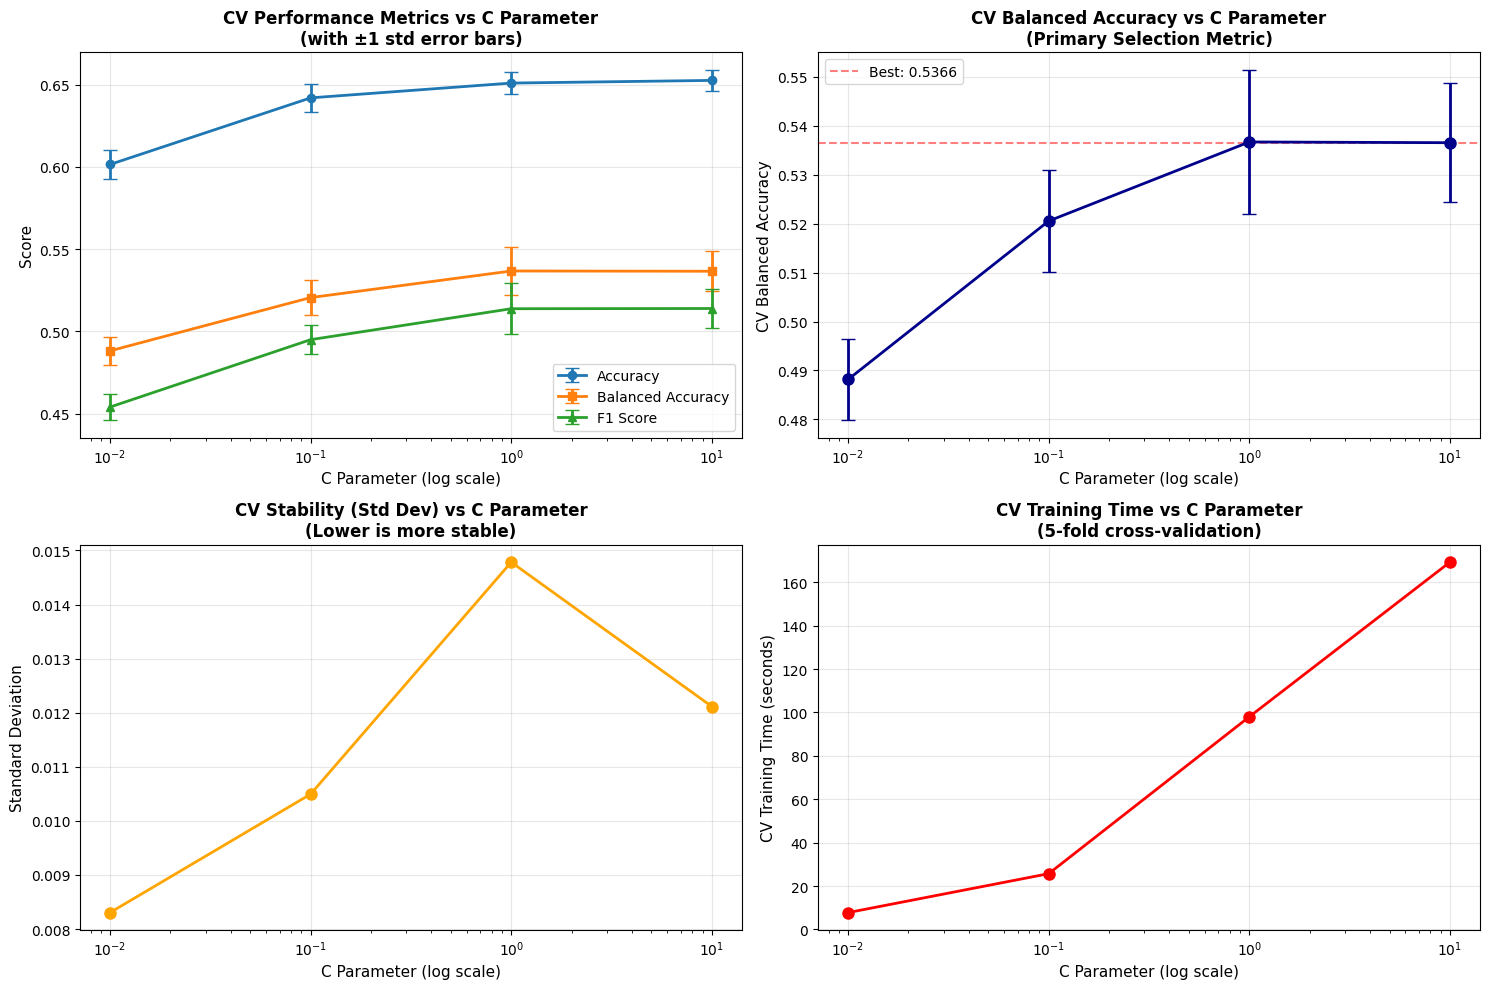

In [8]:
# Visualize C parameter impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance metrics vs C (with error bars)
ax1 = axes[0, 0]
ax1.errorbar(results_C_df['C'], results_C_df['cv_accuracy_mean'], 
             yerr=results_C_df['cv_accuracy_std'], 
             fmt='o-', label='Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='s-', label='Balanced Accuracy', linewidth=2, capsize=5)
ax1.errorbar(results_C_df['C'], results_C_df['cv_f1_mean'], 
             yerr=results_C_df['cv_f1_std'], 
             fmt='^-', label='F1 Score', linewidth=2, capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('C Parameter (log scale)', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('CV Performance Metrics vs C Parameter\n(with ±1 std error bars)', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Balanced Accuracy with tighter focus
ax2 = axes[0, 1]
ax2.errorbar(results_C_df['C'], results_C_df['cv_balanced_accuracy_mean'], 
             yerr=results_C_df['cv_balanced_accuracy_std'], 
             fmt='o-', color='darkblue', linewidth=2, capsize=5, markersize=8)
ax2.axhline(y=best_bal_acc, color='red', linestyle='--', alpha=0.5, 
            label=f'Best: {best_bal_acc:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('C Parameter (log scale)', fontsize=11)
ax2.set_ylabel('CV Balanced Accuracy', fontsize=11)
ax2.set_title('CV Balanced Accuracy vs C Parameter\n(Primary Selection Metric)', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Standard deviation (uncertainty) vs C
ax3 = axes[1, 0]
ax3.plot(results_C_df['C'], results_C_df['cv_balanced_accuracy_std'], 
         'o-', color='orange', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('C Parameter (log scale)', fontsize=11)
ax3.set_ylabel('Standard Deviation', fontsize=11)
ax3.set_title('CV Stability (Std Dev) vs C Parameter\n(Lower is more stable)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: CV training time vs C
ax4 = axes[1, 1]
ax4.plot(results_C_df['C'], results_C_df['cv_time'], 
         'o-', color='red', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('C Parameter (log scale)', fontsize=11)
ax4.set_ylabel('CV Training Time (seconds)', fontsize=11)
ax4.set_title('CV Training Time vs C Parameter\n(5-fold cross-validation)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Experiment - max_iter parameter

In [9]:
## 3. Experiment - max_iter Parameter (Convergence Analysis with CV)

print("="*60)
print("HYPERPARAMETER TUNING: MAX_ITER")
print("="*60)
print(f"Using best C value: {best_C}")
print("Testing max_iter values with 3-fold CV on training set (faster)...")
print("Using SCALED features\n")

max_iter_values = [100, 300]  # Reduced from [100, 200, 500, 1000] for speed
results_iter = []

# Setup cross-validation - reduced to 3 folds for speed
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for max_iter in max_iter_values:
    print(f"\n  max_iter = {max_iter}")
    model = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    
    # Cross-validation on training set (SCALED)
    start = time.time()
    cv_scores_bal_acc = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='balanced_accuracy',
        n_jobs=-1
    )
    cv_scores_f1 = cross_val_score(
        model, X_train_scaled, y_train,  # ← Using scaled data
        cv=kf,
        scoring='f1_macro',
        n_jobs=-1
    )
    cv_time = time.time() - start
    
    # Train once on full training set to check convergence (SCALED)
    model_check = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    model_check.fit(X_train_scaled, y_train)  # ← Using scaled data
    converged = model_check.n_iter_ < max_iter
    actual_iters = model_check.n_iter_
    
    results_iter.append({
        'max_iter': max_iter,
        'cv_balanced_accuracy_mean': cv_scores_bal_acc.mean(),
        'cv_balanced_accuracy_std': cv_scores_bal_acc.std(),
        'cv_f1_mean': cv_scores_f1.mean(),
        'cv_f1_std': cv_scores_f1.std(),
        'actual_iterations': actual_iters,
        'converged': converged,
        'cv_time': cv_time
    })
    
    print(f"    Converged: {converged} (used {actual_iters} iterations)")
    print(f"    CV F1 Score (macro):      {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
    print(f"    CV Balanced Accuracy: {cv_scores_bal_acc.mean():.4f} ± {cv_scores_bal_acc.std():.4f}")
    print(f"    CV time: {cv_time:.3f}s")

results_iter_df = pd.DataFrame(results_iter)

print("\n" + "="*60)
print("CONVERGENCE ANALYSIS RESULTS")
print("="*60)
display(results_iter_df)

# Find best based on F1 score (primary metric)
best_iter_idx_f1 = results_iter_df['cv_f1_mean'].idxmax()
best_max_iter = results_iter_df.loc[best_iter_idx_f1, 'max_iter']

print(f"\nBest max_iter (based on F1 Score): {best_max_iter}")
print(f"CV F1 Score:          {results_iter_df.loc[best_iter_idx_f1, 'cv_f1_mean']:.4f}")
print(f"CV Balanced Accuracy: {results_iter_df.loc[best_iter_idx_f1, 'cv_balanced_accuracy_mean']:.4f}")
print(f"All models converged: {results_iter_df['converged'].all()}")

HYPERPARAMETER TUNING: MAX_ITER
Using best C value: 10.0
Testing max_iter values with 3-fold CV on training set (faster)...
Using SCALED features


  max_iter = 100


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    Converged: False (used 100 iterations)
    CV F1 Score (macro):      0.5122 ± 0.0096
    CV Balanced Accuracy: 0.5339 ± 0.0091
    CV time: 47.744s

  max_iter = 300


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

    Converged: False (used 300 iterations)
    CV F1 Score (macro):      0.5139 ± 0.0119
    CV Balanced Accuracy: 0.5366 ± 0.0121
    CV time: 59.284s

CONVERGENCE ANALYSIS RESULTS


/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,max_iter,cv_balanced_accuracy_mean,cv_balanced_accuracy_std,cv_f1_mean,cv_f1_std,actual_iterations,converged,cv_time
0,100,0.533882,0.009143,0.512157,0.009633,100,False,47.744118
1,300,0.536566,0.012114,0.513901,0.011870,300,False,59.284390



Best max_iter (based on F1 Score): 300
CV F1 Score:          0.5139
CV Balanced Accuracy: 0.5366
All models converged: False


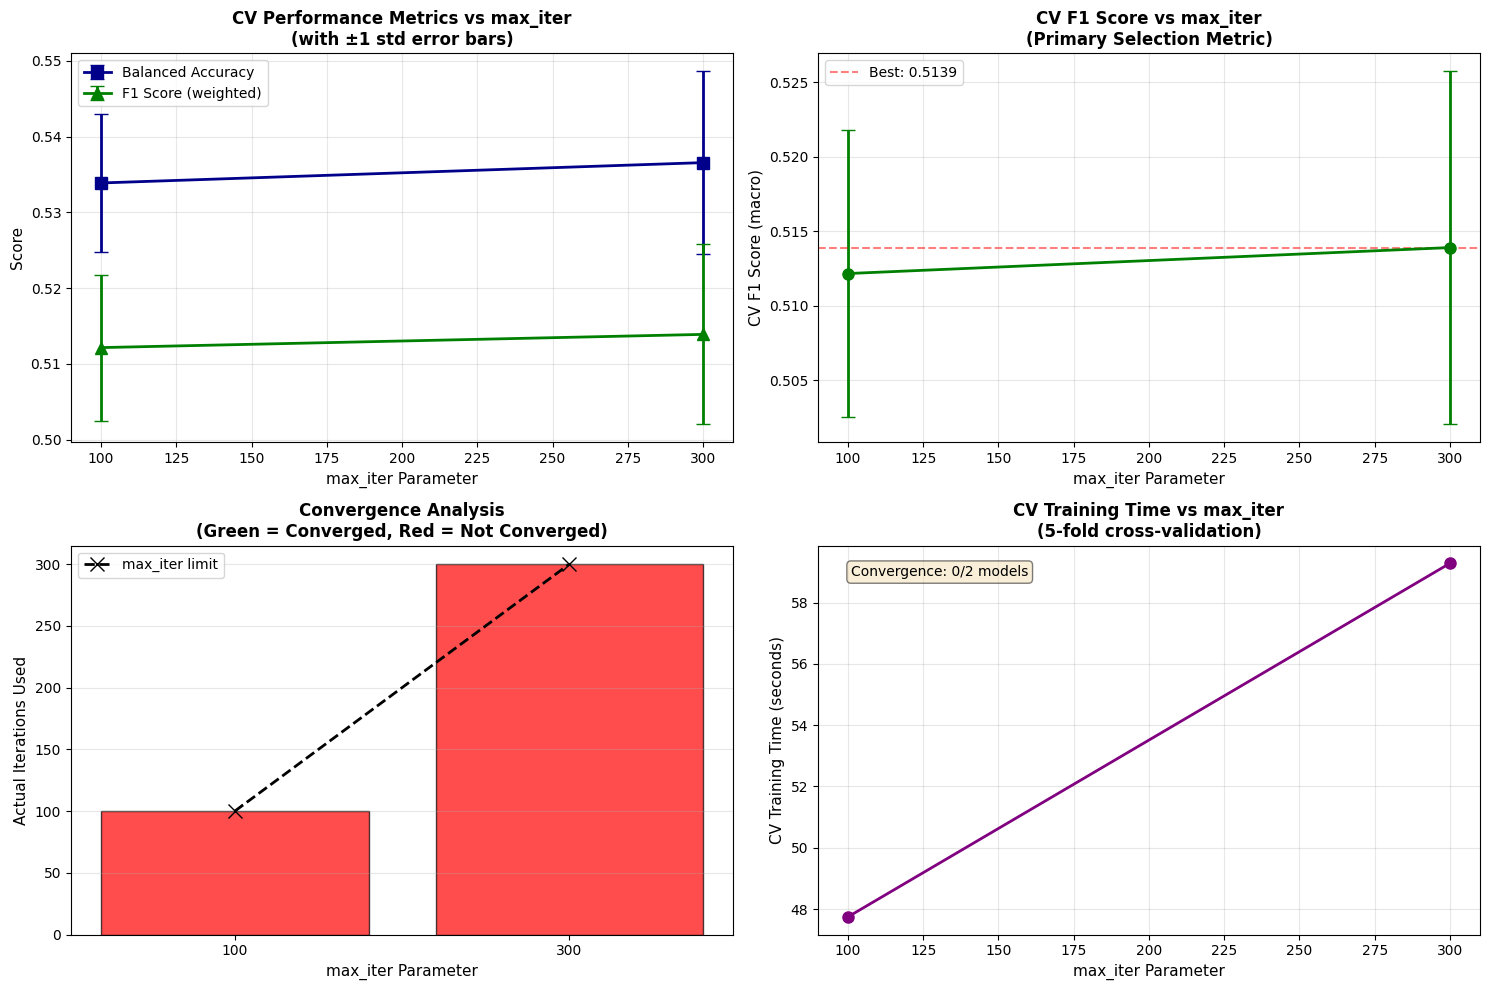

In [10]:
# Visualize max_iter parameter impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Performance metrics vs max_iter (with error bars)
ax1 = axes[0, 0]
ax1.errorbar(results_iter_df['max_iter'], results_iter_df['cv_balanced_accuracy_mean'], 
             yerr=results_iter_df['cv_balanced_accuracy_std'], 
             fmt='s-', label='Balanced Accuracy', linewidth=2, capsize=5, markersize=8, color='darkblue')
ax1.errorbar(results_iter_df['max_iter'], results_iter_df['cv_f1_mean'], 
             yerr=results_iter_df['cv_f1_std'], 
             fmt='^-', label='F1 Score (weighted)', linewidth=2, capsize=5, markersize=8, color='green')
ax1.set_xlabel('max_iter Parameter', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('CV Performance Metrics vs max_iter\n(with ±1 std error bars)', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: F1 Score with tighter focus
ax2 = axes[0, 1]
ax2.errorbar(results_iter_df['max_iter'], results_iter_df['cv_f1_mean'], 
             yerr=results_iter_df['cv_f1_std'], 
             fmt='o-', color='green', linewidth=2, capsize=5, markersize=8)
best_f1_iter = results_iter_df.loc[best_iter_idx_f1, 'cv_f1_mean']
ax2.axhline(y=best_f1_iter, color='red', linestyle='--', alpha=0.5, 
            label=f'Best: {best_f1_iter:.4f}')
ax2.set_xlabel('max_iter Parameter', fontsize=11)
ax2.set_ylabel('CV F1 Score (macro)', fontsize=11)
ax2.set_title('CV F1 Score vs max_iter\n(Primary Selection Metric)', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Convergence behavior - actual iterations used
ax3 = axes[1, 0]
colors = ['green' if conv else 'red' for conv in results_iter_df['converged']]
ax3.bar(range(len(results_iter_df)), results_iter_df['actual_iterations'], 
        color=colors, alpha=0.7, edgecolor='black')
ax3.plot(range(len(results_iter_df)), results_iter_df['max_iter'], 
         'k--', linewidth=2, label='max_iter limit', marker='x', markersize=10)
ax3.set_xticks(range(len(results_iter_df)))
ax3.set_xticklabels(results_iter_df['max_iter'])
ax3.set_xlabel('max_iter Parameter', fontsize=11)
ax3.set_ylabel('Actual Iterations Used', fontsize=11)
ax3.set_title('Convergence Analysis\n(Green = Converged, Red = Not Converged)', 
              fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: CV training time vs max_iter
ax4 = axes[1, 1]
ax4.plot(results_iter_df['max_iter'], results_iter_df['cv_time'], 
         'o-', color='purple', linewidth=2, markersize=8)
ax4.set_xlabel('max_iter Parameter', fontsize=11)
ax4.set_ylabel('CV Training Time (seconds)', fontsize=11)
ax4.set_title('CV Training Time vs max_iter\n(5-fold cross-validation)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add text annotation for convergence summary
convergence_text = f"Convergence: {results_iter_df['converged'].sum()}/{len(results_iter_df)} models"
ax4.text(0.05, 0.95, convergence_text, transform=ax4.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Final Model Evaluation

FINAL MODEL EVALUATION ON TEST SET
Using best hyperparameters from CV:
  C = 10.0
  max_iter = 300
  Using SCALED features

Classification type: Multi-class (7 classes)
Number of training samples: 8000
Number of test samples: 2000

Training final model on entire training set...
Training completed in 15.6041s
Converged: False (used 300 iterations)

Evaluating on test set...
Prediction completed in 0.0064s

TEST SET PERFORMANCE (Unbiased Estimate)
  F1 Score (macro):     0.5273  ← Primary Metric
  Precision (macro):    0.5206
  Recall (macro):       0.5477
  Accuracy:              0.6725

EFFICIENCY METRICS
  Training time:         15.6041s
  Test time:             0.0064s
  Total time:            15.6105s
  Training samples:      8000
  Test samples:          2000
  Time per train sample: 1.9505ms
  Time per test sample:  0.0032ms

CV TRAINING vs TEST SET COMPARISON
F1 Score (macro):
  CV (training):  0.5139 ± 0.0119
  Test:           0.5273
  Difference:     0.0134

⚠ Test F1 score dif

/Users/tomashobza/school/machine_learning/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


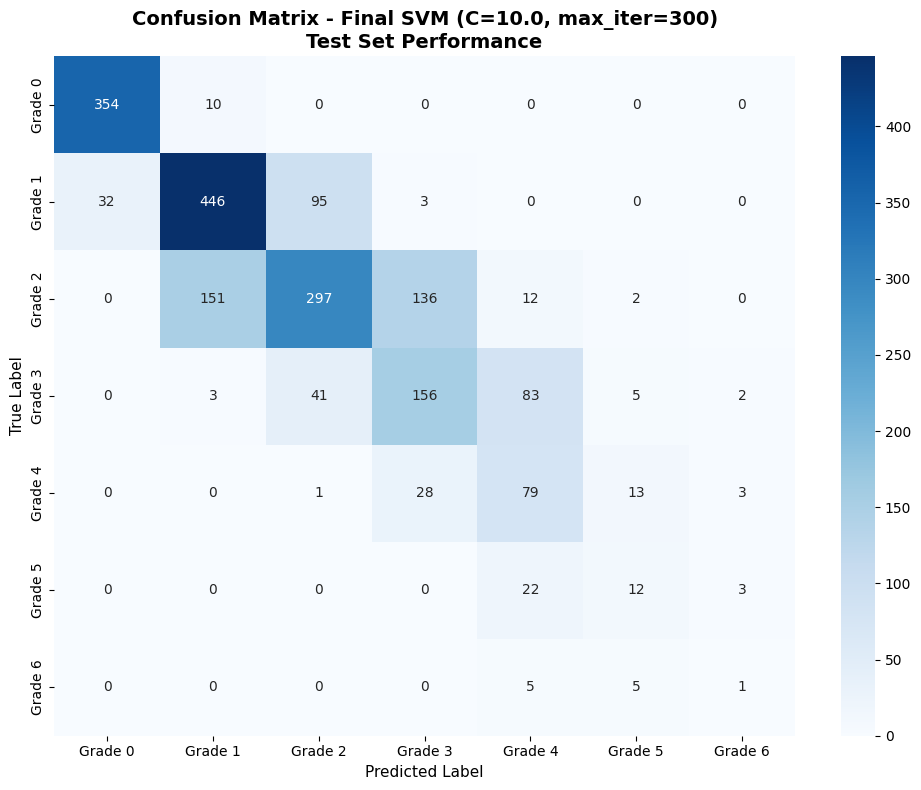


Confusion Matrix Analysis:
  Shape: (7, 7) (7 classes)
  Total predictions: 2000
  Correct predictions (diagonal): 1345
  Misclassifications (off-diagonal): 655

Per-Class Performance:

  Grade 0:
    Samples in test set: 364
    Correctly classified: 354
    Precision: 0.9171
    Recall: 0.9725
    F1 Score: 0.9440

  Grade 1:
    Samples in test set: 576
    Correctly classified: 446
    Precision: 0.7311
    Recall: 0.7743
    F1 Score: 0.7521

  Grade 2:
    Samples in test set: 598
    Correctly classified: 297
    Precision: 0.6843
    Recall: 0.4967
    F1 Score: 0.5756

  Grade 3:
    Samples in test set: 290
    Correctly classified: 156
    Precision: 0.4830
    Recall: 0.5379
    F1 Score: 0.5090

  Grade 4:
    Samples in test set: 124
    Correctly classified: 79
    Precision: 0.3930
    Recall: 0.6371
    F1 Score: 0.4862

  Grade 5:
    Samples in test set: 37
    Correctly classified: 12
    Precision: 0.3243
    Recall: 0.3243
    F1 Score: 0.3243

  Grade 6:
    Sam

,0
Model,LinearSVC
Classification Type,Multi-class
Number of Classes,7
F1 Score (macro),0.527306
Precision (macro),0.520574
Recall (macro),0.547679
Accuracy,0.6725
Train Time (s),15.604131
Test Time (s),0.006356
Training Samples,8000


In [11]:
## 4. Final Model Evaluation on Test Set

print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print(f"Using best hyperparameters from CV:")
print(f"  C = {best_C}")
print(f"  max_iter = {best_max_iter}")
print(f"  Using SCALED features")
print()

# Determine if binary or multi-class classification
n_classes = len(y.unique())
is_binary = n_classes == 2
print(f"Classification type: {'Binary' if is_binary else f'Multi-class ({n_classes} classes)'}")
print(f"Number of training samples: {len(X_train_scaled)}")
print(f"Number of test samples: {len(X_test_scaled)}")
print()

# Train final model with best hyperparameters on SCALED training data
final_model = LinearSVC(C=best_C, class_weight='balanced', max_iter=best_max_iter, random_state=42)

print("Training final model on entire training set...")
train_start = time.time()
final_model.fit(X_train_scaled, y_train)
train_time = time.time() - train_start

print(f"Training completed in {train_time:.4f}s")
print(f"Converged: {final_model.n_iter_ < best_max_iter} (used {final_model.n_iter_} iterations)")

# Predictions on test set (SCALED)
print("\nEvaluating on test set...")
test_start = time.time()
y_pred_final = final_model.predict(X_test_scaled)
test_time = time.time() - test_start

print(f"Prediction completed in {test_time:.4f}s")

# Comprehensive metrics - using macro averaging for non-binary, binary for binary
if is_binary:
    test_f1 = f1_score(y_test, y_pred_final, average='binary')
    test_precision = precision_score(y_test, y_pred_final, average='binary')
    test_recall = recall_score(y_test, y_pred_final, average='binary')
    metric_type = "binary"
else:
    test_f1 = f1_score(y_test, y_pred_final, average='macro')
    test_precision = precision_score(y_test, y_pred_final, average='macro')
    test_recall = recall_score(y_test, y_pred_final, average='macro')
    metric_type = "macro"

test_acc = accuracy_score(y_test, y_pred_final)

print("\n" + "="*60)
print("TEST SET PERFORMANCE (Unbiased Estimate)")
print("="*60)
print(f"  F1 Score ({metric_type}):     {test_f1:.4f}  ← Primary Metric")
print(f"  Precision ({metric_type}):    {test_precision:.4f}")
print(f"  Recall ({metric_type}):       {test_recall:.4f}")
print(f"  Accuracy:              {test_acc:.4f}")
print()
print("EFFICIENCY METRICS")
print("="*60)
print(f"  Training time:         {train_time:.4f}s")
print(f"  Test time:             {test_time:.4f}s")
print(f"  Total time:            {train_time + test_time:.4f}s")
print(f"  Training samples:      {len(X_train_scaled)}")
print(f"  Test samples:          {len(X_test_scaled)}")
print(f"  Time per train sample: {train_time/len(X_train_scaled)*1000:.4f}ms")
print(f"  Time per test sample:  {test_time/len(X_test_scaled)*1000:.4f}ms")

# Compare CV training performance vs test performance
print("\n" + "="*60)
print("CV TRAINING vs TEST SET COMPARISON")
print("="*60)
cv_best_f1 = results_C_df.loc[best_C_idx_f1, 'cv_f1_mean']
cv_best_f1_std = results_C_df.loc[best_C_idx_f1, 'cv_f1_std']

print(f"F1 Score ({metric_type}):")
print(f"  CV (training):  {cv_best_f1:.4f} ± {cv_best_f1_std:.4f}")
print(f"  Test:           {test_f1:.4f}")
print(f"  Difference:     {abs(cv_best_f1 - test_f1):.4f}")

# Interpretation
if abs(cv_best_f1 - test_f1) < cv_best_f1_std:
    print("\n✓ Test F1 score is within CV std dev → Good generalization!")
else:
    print("\n⚠ Test F1 score differs from CV estimate → Check for overfitting/dataset shift")

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
# Get actual class names from the data
class_names = sorted(y.unique())
print(classification_report(y_test, y_pred_final, target_names=[f'Grade {g}' for g in class_names]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=[f'Grade {g}' for g in class_names],
            yticklabels=[f'Grade {g}' for g in class_names])
plt.title(f'Confusion Matrix - Final SVM (C={best_C}, max_iter={best_max_iter})\nTest Set Performance', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Analysis:")
print(f"  Shape: {cm.shape} ({len(class_names)} classes)")
print(f"  Total predictions: {cm.sum()}")
print(f"  Correct predictions (diagonal): {cm.diagonal().sum()}")
print(f"  Misclassifications (off-diagonal): {cm.sum() - cm.diagonal().sum()}")

# Per-class performance
print("\nPer-Class Performance:")
for idx, grade in enumerate(class_names):
    true_positives = cm[idx, idx]
    false_negatives = cm[idx, :].sum() - true_positives
    false_positives = cm[:, idx].sum() - true_positives
    total_actual = cm[idx, :].sum()
    
    class_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    class_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall) if (class_precision + class_recall) > 0 else 0
    
    print(f"\n  Grade {grade}:")
    print(f"    Samples in test set: {total_actual}")
    print(f"    Correctly classified: {true_positives}")
    print(f"    Precision: {class_precision:.4f}")
    print(f"    Recall: {class_recall:.4f}")
    print(f"    F1 Score: {class_f1:.4f}")

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model: LinearSVC")
print(f"Task: {'Binary' if is_binary else 'Multi-class'} classification ({len(class_names)} loan grades)")
print(f"Hyperparameters: C={best_C}, max_iter={best_max_iter}, class_weight='balanced'")
print(f"Preprocessing: StandardScaler (zero mean, unit variance)")
print(f"Convergence: {final_model.n_iter_} iterations")
print()
print("PERFORMANCE METRICS:")
print(f"  F1 Score ({metric_type}):     {test_f1:.4f}")
print(f"  Precision ({metric_type}):    {test_precision:.4f}")
print(f"  Recall ({metric_type}):       {test_recall:.4f}")
print(f"  Accuracy:              {test_acc:.4f}")
print()
print("EFFICIENCY METRICS:")
print(f"  Training time:         {train_time:.4f}s")
print(f"  Test time:             {test_time:.4f}s")
print(f"  Training samples:      {len(X_train_scaled)}")
print(f"  Test samples:          {len(X_test_scaled)}")
print("="*60)

# Create summary dictionary for easy reference
final_results = {
    'Model': 'LinearSVC',
    'Classification Type': 'Binary' if is_binary else 'Multi-class',
    'Number of Classes': n_classes,
    f'F1 Score ({metric_type})': test_f1,
    f'Precision ({metric_type})': test_precision,
    f'Recall ({metric_type})': test_recall,
    'Accuracy': test_acc,
    'Train Time (s)': train_time,
    'Test Time (s)': test_time,
    'Training Samples': len(X_train_scaled),
    'Test Samples': len(X_test_scaled),
    'C': best_C,
    'max_iter': best_max_iter,
    'Convergence Iterations': final_model.n_iter_
}

print("\n" + "="*60)
print("RESULTS SUMMARY TABLE")
print("="*60)
results_summary_df = pd.DataFrame([final_results])
display(results_summary_df.T)
print("="*60)